# 1. Setup Paths

In [13]:
import tensorflow as tf

tf.test.is_built_with_cuda()

tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
print(len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
import os

In [15]:
CUSTOM_MODEL_NAME = 'indrecognition4' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [16]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [17]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [18]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [30]:
import object_detection

# 2. Create Label Map

In [31]:
labels = [{'name':'plat-nomor', 'id':1}]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [128]:
# OPTIONAL IF RUNNING ON COLAB

ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [129]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [130]:
#Biasa error di child index out range 
#Solusi cek : tensorflow>scripts>generate tfrecord (line 88 index)
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy Model Config to Training Folder

In [131]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# 5. Update Config For Transfer Learning

In [132]:
#update config line 165 in Tensorflow\workspace\models\my_ssd_mobnet
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [133]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [134]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matc

In [135]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [136]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [137]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [382]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [383]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=100000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [384]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\indrecognition4 --pipeline_config_path=Tensorflow\workspace\models\indrecognition4\pipeline.config --num_train_steps=100000


In [23]:
!{command}

^C


# 7. Evaluate the Model

In [385]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [386]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\indrecognition4 --pipeline_config_path=Tensorflow\workspace\models\indrecognition4\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\indrecognition4


In [ ]:
!{command}

# 8. Load Train Model From Checkpoint

In [19]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [20]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-501')).expect_partial()
#ubah checkpoint di D:\ANPR\Tensorflow\workspace\models\my_ssd_mobnet sesuai checkpoint
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [21]:
from cv2 import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [22]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [116]:
#IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Plat-Nomor-Cantik-Twitter_jpg.rf.b6e6e1fa75380a8549d13767e73e5778.jpg')
IMAGE_PATH = r'D:\dataset plat\DATA TESTING\73 - Copy.jpg'

Skor Kepercayaan Tertinggi: 0.9960431


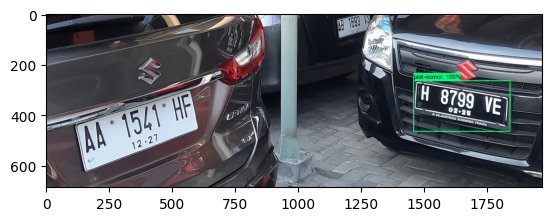

In [117]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor) #storre in this

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=1,
            min_score_thresh=.4,
            agnostic_mode=False)
#print(detections['detection_scores'])
# Mencari skor kepercayaan tertinggi dari deteksi kotak
max_score_index = np.argmax(detections['detection_scores'])
max_score = detections['detection_scores'][max_score_index]

# Print skor kepercayaan tertinggi
print("Skor Kepercayaan Tertinggi:", max_score)
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Apply OCR Detection & Region Classification

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.38646105 0.74089706 0.67773175 0.93562365]
[ 265.49874088 1460.30810416  465.6017139  1844.11420584]
58
([[29, 19], [67, 19], [67, 77], [29, 77]], 'H', 0.3196187310224765)
81
([[275, 55], [363, 55], [363, 136], [275, 136]], 'VE', 0.8774022159460252)
68.71567181793667
([[105.95315215481958, 15.05494547078594], [262.4746942054219, 42.80153635103592], [244.04684784518042, 129.94505452921405], [86.5253057945781, 102.19846364896408]], '8799', 0.9730104207992554)
26.592667328670785
([[139.05217527923597, 97.11391864486748], [236.9387205029579, 112.30251824426787], [229.94782472076403, 145.88608135513252], [133.0612794970421, 130.69748175573213]], '02-20', 0.25448577782140774)
['H', 'VE', '8799', '02-20']


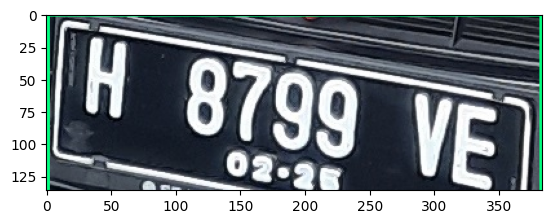

In [118]:
import easyocr
import numpy as np

image = image_np_with_detections
detection_boxes = detections['detection_boxes']
detection_classes = detections['detection_classes']

# Find the index with the maximum score
max_score_index = np.argmax(detections['detection_scores'])

# Take the detection with the maximum score
boxes = np.array([detection_boxes[max_score_index]], dtype=np.float32)
classes = np.array([detection_classes[max_score_index]], dtype=np.float32)

# Modify the boxes format to [y_min, x_min, y_max, x_max]
boxes = np.array([[boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]]], dtype=np.float32)

# Now boxes and classes are float32 arrays and can be used for further processing
width = image.shape[1]
height = image.shape[0]

# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(box)
    roi = box * [height, width, height, width]
    print(roi)
    
    # Get 68% area
    roi[2] = roi[0] + 0.68 * (roi[2] - roi[0])
    
    region = image[int(roi[0]):int(roi[2]), int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['id'])  # bisa id
    ocr_result = reader.readtext(region)
    #print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    
plat_number_fix = []
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    plat_number_fix.append(result[1])
    print(result)

print(plat_number_fix)


In [119]:
# Data yang diberikan
data = ocr_result

# Mengurutkan data berdasarkan koordinatnya
sorted_data = sorted(data, key=lambda x: (x[0][0][0], x[0][0][1]))

def post_process_text(text):
    # Menghapus karakter non-huruf dan non-angka serta spasi berlebihan
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

# Menampilkan label sesuai urutan koordinatnya
output_labels = [item[1] for item in sorted_data]
upper_result = " ".join(output_labels).upper()
result = post_process_text(upper_result) 

print('Nomor Kendaraan Terbaca dan Terurut-> '+ result)  # Output: "AB KS 5 1021"
import pandas as pd

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('DATA PLAT NOMOR.xlsx',dtype={'ID':'string'})

baca = result
data_column = df.values

def KolomFunc1():  # Jika depannya 1 huruf
    data_found = False  # Variabel untuk melacak apakah ada data yang sesuai
    for i in data_column:
        if i[2] == baca[0]:
            if i[3] == 'DEPAN':
                if ('**') in str(i[4]):
                    if baca[-3] in str(i[4]):  # Cari karakter di string list
                        print('Asal Wilayah Nomor Kendaraan -> '+i[1])
                        data_found = True  # Data ditemukan, ubah menjadi True
                else:
                    if baca[-2] in str(i[4]):  # Cari karakter di string list
                        print('Asal Wilayah Nomor Kendaraan -> '+i[1])
                        data_found = True  # Data ditemukan, ubah menjadi True
            if i[3] == 'BELAKANG':
                if baca[-1] in str(i[4]):  # Cari karakter di string list
                    print('Asal Wilayah Nomor Kendaraan -> '+i[1])
                    data_found = True  # Data ditemukan, ubah menjadi True

    if not data_found:  # Jika tidak ada data yang sesuai ditemukan
        print('Tidak Ditemukan Wilayah Spesifik')

def KolomFunc2():  # Jika depannya 2 huruf
    data_found = False  # Variabel untuk melacak apakah ada data yang sesuai
    for i in data_column:
        if i[2] == baca[:2]:
            if i[3] == 'DEPAN':
                if ('**') in str(i[4]):
                    if baca[-3] in str(i[4]):  # Cari karakter di string list
                        print('Asal Wilayah Nomor Kendaraan -> '+i[1])
                        data_found = True  # Data ditemukan, ubah menjadi True
                else:
                    if baca[-2] in str(i[4]):  # Cari karakter di string list
                        print('Asal Wilayah Nomor Kendaraan -> '+i[1])
                        data_found = True  # Data ditemukan, ubah menjadi True
            if i[3] == 'BELAKANG':
                if baca[-1] in str(i[4]):  # Cari karakter di string list
                    print('Asal Wilayah Nomor Kendaraan -> '+i[1])
                    data_found = True  # Data ditemukan, ubah menjadi True
    if not data_found:  # Jika tidak ada data yang sesuai ditemukan
        print('Tidak Ditemukan Wilayah Spesifik')
                    
#baca[:2]
if (' ') not in baca[:2]:
    KolomFunc2()
else :
    KolomFunc1()

Nomor Kendaraan Terbaca dan Terurut-> H 8799 0220 VE
Asal Wilayah Nomor Kendaraan -> Kabupaten Demak


--------------------

In [12]:
#POST PROCESS BUAT MOTONG SYMBOL
import re

def post_process_text(text):
    # Menghapus karakter non-huruf dan non-angka serta spasi berlebihan
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

# Contoh teks sebelum post-processing
original_text = "AD 1/55 AJ"
processed_text = post_process_text(original_text)

# Teks setelah post-processing
print(processed_text)


AD 155 AJ


-------------------